<a href="https://colab.research.google.com/github/lw-miles24/CompModNervSys-final/blob/main/simulate_BallAndStick_FXS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize session

Install neuron as usual.

In [1]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

Mount the rest of the model files from the github repository.

In [2]:
repo_name = 'CompModNervSys-final'
if 'google.colab' in str(get_ipython()):
    import os
    if not os.path.exists(repo_name):
        !git clone https://github.com/lw-miles24/{repo_name}.git # downloads repository into our Google colab session's file system

    os.chdir(repo_name) # Changing working directory to downloaded repository

# Compile mechanisms
!nrnivmodl mechanisms

/content/CompModNervSys-final
Mod files: "mechanisms/mechanisms/kv.mod" "mechanisms/mechanisms/na.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Import the packages we'll be using.

In [3]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib.pyplot as plt
import plotly
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()


# Setup model

Create the Ball and Stick neuron model

Make `NetStim`s to drive synapses and `NetCons` to connect `NetStim`s to the synapses.  

Detect if cell fired an AP by checking for a threshold voltage in the AIS.

In [4]:
def ap_fired(v_vec_AIS,t_vec,threshold=0):
    # v_vec_AIS = vector of AIS voltage
    # t_vec = time vector
    # threshold = mV threshold for AP firing
    h.run()
    for i in np.arange(0,len(t_vec)):
        if v_vec_AIS[i] > threshold:
            return True
    return False

Define binary sort.

In [5]:
import timeit # used to avoid infinite loop below

def find_threshold(nc_estim,v_vec_AIS,t_vec,threshold=0,low=0.01,high=5,thresh_err=0.02,max_time=100,print_out=False):
    # nc_estim - Current clamp object to vary amplitude of
    # spike_times - NEURON Vector of spike times
    # num_aps - Number of APs to require to consider above threshold
    # low - starting lower bound of search
    # high - starting upper bound of search
    # thresh_err - criteria to end search, relative window size (high-low)/low
    # print_out - True or False, use for troubleshooting, prints out status during search
    start_time = timeit.default_timer()

    nc_estim.weight[0] = high
    # First course search
    while ((low == 0.01 or high == 5) and (timeit.default_timer() - start_time < max_time)):
        if (ap_fired(v_vec_AIS,t_vec,threshold)):
            high = nc_estim.weight[0]
            nc_estim.weight[0] = high/2
            # print('High loop; high = ')
            # print(nc_estim.weight[0])
        else:
            low = nc_estim.weight[0]
            nc_estim.weight[0] = 2*low
            # print('Low loop; low = ')
            # print(nc_estim.weight[0])
        if print_out:
            print('Coarse: Weight = {}, high = {}, low = {}'.format(nc_estim.weight[0],high,low))
        if (low > high):
            print('Search terminated early, threshold above upper limit {}'.format(high))
            return high
    # At this point, high value is not more than 2 x the threshold and low is not less than half the threshold
    # Finer search, narrow bounds of threshold window
    while ( abs(high/low - 1) > thresh_err ):
        if print_out:
            print('Window size = {} %%'.format(100*abs(high/low - 1)))
        if (ap_fired(v_vec_AIS,t_vec,threshold)):
            high = nc_estim.weight[0]
            if print_out:
                print('Fired {} weight'.format(nc_estim.weight[0]))
        else:
            if print_out:
                print('No AP {} weight'.format(nc_estim.weight[0]))
            low = nc_estim.weight[0]
        nc_estim.weight[0] = (high+low)/2
        if print_out:
            print('Fine: Weight = {}, high = {}, low = {}'.format(nc_estim.weight[0],high,low))
        # fig.add_trace(go.Scatter(x=t_vec,y=V_vec,name='Vm',line=dict(color='rgb(0,0,0)')),secondary_y = False)
        # fig.show()
    print('Threshold to elicit APs = {:.5f} weight ({:.2f} %% error)'.format(nc_estim.weight[0],thresh_err*100))
    return high # returns upper range of window to ensure amplitude is above threshold

# Dendritic AIS - WT

In [6]:
from ballandstick import BallAndStick

ais_mode = 'dend' # set to either 'soma' or 'dend'
ais_loc = 0.028 # if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
               # benchmark values from Hodapp et al. 2022, ranging 0 to 1 (along 200 µm basal dendrite)
               # mean axonal distance: 0.028 (5.7 µm)
               # 95th percentile:      0.06   (12 µm)
ais_length = 25.9 # µm; from Booker et al. 2020
cell_WT_dAIS = BallAndStick(0,ais_mode,ais_loc,ais_length=ais_length)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)
# Simulation parameter settings
h.celsius = 37 # degC
h.steps_per_ms = 1/0.025
h.dt = 0.025 # ms
h.tstop = 20 # ms
h.v_init = -69 # mV

# Stimulation
iclamp = h.IClamp(cell_WT_dAIS.soma(0.5))
iclamp.delay = 5 # ms
iclamp.dur = 5 # ms
iclamp.amp = 0 # ms
iclamp_i = h.Vector().record(iclamp._ref_i)

# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.438 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
                    # 0.438 = 87.6 µm along 200 µm basal dendrite (average stim
                    # location used in Hodapp et al. 2022 simulations)
exc_syn = h.Exp2Syn(cell_WT_dAIS.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # ms - rise time (taken from Hodapp 2022 supp materials)
exc_syn.tau2 = 5 # ms - decay time
exc_syn.e = 0 # mV - eversal potential

# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell_WT_dAIS.soma(0.5))
inh_syn.tau1 = 1.6 # ms
inh_syn.tau2 = 11 # ms
inh_syn.e = -75 # mV

# synaptic current recordings
exc_syn_i = h.Vector().record(exc_syn._ref_i)
exc_syn_g = h.Vector().record(exc_syn._ref_g)
inh_syn_i = h.Vector().record(inh_syn._ref_i)
inh_syn_g = h.Vector().record(inh_syn._ref_g)

# NetStim to simulate excitatory presynaptic spikes
estim = h.NetStim()
estim.number = 1
estim.interval = 10 # ms - interval between spikes
estim.start = 5 # ms
estim.noise = 0

# NetCon to connect excitatory presynaptic spikes to excitatory postsynaptic conductance
nc_estim = h.NetCon(estim,exc_syn)
nc_estim.delay = 1 # ms - synaptic delay
nc_estim.weight[0] = 1 # µS - peak conductance

# NetStim to simulate inhibitory presynaptic spikes
istim = h.NetStim()
istim.number = 1
istim.interval = 10 # ms - interval between spikes
istim.start = 5 # ms
istim.noise = 0

# NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance
nc_istim = h.NetCon(istim,inh_syn)
nc_istim.delay = 1 # ms - synaptic delay
nc_istim.weight[0] = 1 # µS - peak conductance


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
             `--------------------|       BallAndStick[0].ais_prox(0-1)
                                   `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                         `------------------------|       BallAndStick[0].axon(0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
    `--------------------|       BallAndStick[0].apic[0](0-1)
                          `----|       BallAndStick[0].apic[1](0-1)
                          `----|       BallAndStick[0].apic[2](0-1)



Simulate a range of excitatory and inhibitory weights from Hodapp et al. 2022.

In [7]:
# set bounds of inhibitory & excitatory input to test
inh_range = [0.0,0.08] # µS
num_samples = 13 # 5
exc_range = [0.001,0.12] # µS

# setup
WT_dAIS_threshfire = []
inh_values = np.linspace(inh_range[0],inh_range[1],num_samples)

# run simulations, find minimum excitatory weight needed to get AP
for i in np.arange(0,len(inh_values)):
    nc_istim.weight[0] = inh_values[i]
    WT_dAIS_threshfire.append(find_threshold(nc_estim,cell_WT_dAIS.ais_v,t_vec,low=exc_range[0],high=exc_range[1]))

print(WT_dAIS_threshfire)

Threshold to elicit APs = 0.00873 weight (2.00 %% error)
Threshold to elicit APs = 0.01413 weight (2.00 %% error)
Threshold to elicit APs = 0.01808 weight (2.00 %% error)
Threshold to elicit APs = 0.02064 weight (2.00 %% error)
Threshold to elicit APs = 0.02354 weight (2.00 %% error)
Threshold to elicit APs = 0.02773 weight (2.00 %% error)
Threshold to elicit APs = 0.03470 weight (2.00 %% error)
Threshold to elicit APs = 0.04446 weight (2.00 %% error)
Threshold to elicit APs = 0.05818 weight (2.00 %% error)
Threshold to elicit APs = 0.07770 weight (2.00 %% error)
Threshold to elicit APs = 0.10605 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
[0.0087861328125, 0.014248046875, 0.018199218750000003, 0.020755859374999998, 0.02377734375, 0.027960937499999998, 0.034933593750000005, 0.0446953125, 0.058640625, 0.07816406249999999, 0.10698437499999999, 0.12, 0.12]


# Dendritic AIS - FXS

In [8]:
from ballandstick import BallAndStick

ais_mode = 'dend' # set to either 'soma' or 'dend'
ais_loc = 0.028 # if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
               # benchmark values from Hodapp et al. 2022, ranging 0 to 1 (along 200 µm basal dendrite)
               # mean axonal distance: 0.028 (5.7 µm)
               # 95th percentile:      0.06   (12 µm)
ais_length = 31.9 # µm; from Booker et al. 2020
cell_FXS_dAIS = BallAndStick(0,ais_mode,ais_loc,ais_length=ais_length)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)
# Simulation parameter settings
h.celsius = 37 # degC
h.steps_per_ms = 1/0.025
h.dt = 0.025 # ms
h.tstop = 20 # ms
h.v_init = -69 # mV

# Stimulation
iclamp = h.IClamp(cell_FXS_dAIS.soma(0.5))
iclamp.delay = 5 # ms
iclamp.dur = 5 # ms
iclamp.amp = 0 # ms
iclamp_i = h.Vector().record(iclamp._ref_i)

# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.438 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
                    # 0.438 = 87.6 µm along 200 µm basal dendrite (average stim
                    # location used in Hodapp et al. 2022 simulations)
exc_syn = h.Exp2Syn(cell_FXS_dAIS.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # ms - rise time (taken from Hodapp 2022 supp materials)
exc_syn.tau2 = 5 # ms - decay time
exc_syn.e = 0 # mV - eversal potential

# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell_FXS_dAIS.soma(0.5))
inh_syn.tau1 = 1.6 # ms
inh_syn.tau2 = 11 # ms
inh_syn.e = -75 # mV

# synaptic current recordings
exc_syn_i = h.Vector().record(exc_syn._ref_i)
exc_syn_g = h.Vector().record(exc_syn._ref_g)
inh_syn_i = h.Vector().record(inh_syn._ref_i)
inh_syn_g = h.Vector().record(inh_syn._ref_g)

# NetStim to simulate excitatory presynaptic spikes
estim = h.NetStim()
estim.number = 1
estim.interval = 10 # ms - interval between spikes
estim.start = 5 # ms
estim.noise = 0

# NetCon to connect excitatory presynaptic spikes to excitatory postsynaptic conductance
nc_estim = h.NetCon(estim,exc_syn)
nc_estim.delay = 1 # ms - synaptic delay
nc_estim.weight[0] = 1 # µS - peak conductance

# NetStim to simulate inhibitory presynaptic spikes
istim = h.NetStim()
istim.number = 1
istim.interval = 10 # ms - interval between spikes
istim.start = 5 # ms
istim.noise = 0

# NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance
nc_istim = h.NetCon(istim,inh_syn)
nc_istim.delay = 1 # ms - synaptic delay
nc_istim.weight[0] = 1 # µS - peak conductance


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
             `--------------------|       BallAndStick[0].ais_prox(0-1)
                                   `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                         `------------------------|       BallAndStick[0].axon(0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
    `--------------------|       BallAndStick[0].apic[0](0-1)
                          `----|       BallAndStick[0].apic[1](0-1)
                          `----|       BallAndStick[0].apic[2](0-1)
|-----|       BallAndStick[0].soma(0-1)
       `-----------------------------------------------------------------------------------------------------------------------------------

In [9]:
# set bounds of inhibitory & excitatory input to test
inh_range = [0.0,0.08] # µS
num_samples = 13 # 5
exc_range = [0.001,0.12] # µS

# setup
FXS_dAIS_threshfire = []
inh_values = np.linspace(inh_range[0],inh_range[1],num_samples)

# run simulations, find minimum excitatory weight needed to get AP
for i in np.arange(0,len(inh_values)):
    nc_istim.weight[0] = inh_values[i]
    FXS_dAIS_threshfire.append(find_threshold(nc_estim,cell_FXS_dAIS.ais_v,t_vec,low=exc_range[0],high=exc_range[1]))

print(FXS_dAIS_threshfire)

Threshold to elicit APs = 0.00850 weight (2.00 %% error)
Threshold to elicit APs = 0.01367 weight (2.00 %% error)
Threshold to elicit APs = 0.01762 weight (2.00 %% error)
Threshold to elicit APs = 0.02017 weight (2.00 %% error)
Threshold to elicit APs = 0.02273 weight (2.00 %% error)
Threshold to elicit APs = 0.02587 weight (2.00 %% error)
Threshold to elicit APs = 0.03098 weight (2.00 %% error)
Threshold to elicit APs = 0.03842 weight (2.00 %% error)
Threshold to elicit APs = 0.04888 weight (2.00 %% error)
Threshold to elicit APs = 0.06282 weight (2.00 %% error)
Threshold to elicit APs = 0.08142 weight (2.00 %% error)
Threshold to elicit APs = 0.10791 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
[0.0085537109375, 0.013783203125, 0.017734375, 0.020291015625, 0.02284765625, 0.0261015625, 0.03121484375, 0.03865234375, 0.04934375, 0.06328906249999999, 0.08188281249999999, 0.10884374999999999, 0.12]


# Somatic AIS - WT

In [10]:
from ballandstick import BallAndStick

ais_mode = 'soma' # set to either 'soma' or 'dend'
ais_loc = 0 # if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
               # benchmark values from Hodapp et al. 2022, ranging 0 to 1 (along 200 µm basal dendrite)
               # mean axonal distance: 0.028 (5.7 µm)
               # 95th percentile:      0.06   (12 µm)
ais_length = 25.6 # µm; from Booker et al. 2020
cell_WT_sAIS = BallAndStick(0,ais_mode,ais_loc,ais_length=ais_length)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)
# Simulation parameter settings
h.celsius = 37 # degC
h.steps_per_ms = 1/0.025
h.dt = 0.025 # ms
h.tstop = 20 # ms
h.v_init = -69 # mV

# Stimulation
iclamp = h.IClamp(cell_WT_sAIS.soma(0.5))
iclamp.delay = 5 # ms
iclamp.dur = 5 # ms
iclamp.amp = 0 # ms
iclamp_i = h.Vector().record(iclamp._ref_i)

# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.438 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
                    # 0.438 = 87.6 µm along 200 µm basal dendrite (average stim
                    # location used in Hodapp et al. 2022 simulations)
exc_syn = h.Exp2Syn(cell_WT_sAIS.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # ms - rise time (taken from Hodapp 2022 supp materials)
exc_syn.tau2 = 5 # ms - decay time
exc_syn.e = 0 # mV - eversal potential

# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell_WT_sAIS.soma(0.5))
inh_syn.tau1 = 1.6 # ms
inh_syn.tau2 = 11 # ms
inh_syn.e = -75 # mV

# synaptic current recordings
exc_syn_i = h.Vector().record(exc_syn._ref_i)
exc_syn_g = h.Vector().record(exc_syn._ref_g)
inh_syn_i = h.Vector().record(inh_syn._ref_i)
inh_syn_g = h.Vector().record(inh_syn._ref_g)

# NetStim to simulate excitatory presynaptic spikes
estim = h.NetStim()
estim.number = 1
estim.interval = 10 # ms - interval between spikes
estim.start = 5 # ms
estim.noise = 0

# NetCon to connect excitatory presynaptic spikes to excitatory postsynaptic conductance
nc_estim = h.NetCon(estim,exc_syn)
nc_estim.delay = 1 # ms - synaptic delay
nc_estim.weight[0] = 1 # µS - peak conductance

# NetStim to simulate inhibitory presynaptic spikes
istim = h.NetStim()
istim.number = 1
istim.interval = 10 # ms - interval between spikes
istim.start = 5 # ms
istim.noise = 0

# NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance
nc_istim = h.NetCon(istim,inh_syn)
nc_istim.delay = 1 # ms - synaptic delay
nc_istim.weight[0] = 1 # µS - peak conductance


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
             `--------------------|       BallAndStick[0].ais_prox(0-1)
                                   `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                         `------------------------|       BallAndStick[0].axon(0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
    `--------------------|       BallAndStick[0].apic[0](0-1)
                          `----|       BallAndStick[0].apic[1](0-1)
                          `----|       BallAndStick[0].apic[2](0-1)
|-----|       BallAndStick[0].soma(0-1)
       `-----------------------------------------------------------------------------------------------------------------------------------

In [11]:
# set bounds of inhibitory & excitatory input to test
inh_range = [0.0,0.08] # µS
num_samples = 13 # 5
exc_range = [0.001,0.12] # µS

# setup
WT_sAIS_threshfire = []
inh_values = np.linspace(inh_range[0],inh_range[1],num_samples)

# run simulations, find minimum excitatory weight needed to get AP
for i in np.arange(0,len(inh_values)):
    nc_istim.weight[0] = inh_values[i]
    WT_sAIS_threshfire.append(find_threshold(nc_estim,cell_WT_sAIS.ais_v,t_vec,low=exc_range[0],high=exc_range[1]))

print(WT_sAIS_threshfire)

Threshold to elicit APs = 0.00896 weight (2.00 %% error)
Threshold to elicit APs = 0.01460 weight (2.00 %% error)
Threshold to elicit APs = 0.01832 weight (2.00 %% error)
Threshold to elicit APs = 0.02134 weight (2.00 %% error)
Threshold to elicit APs = 0.02633 weight (2.00 %% error)
Threshold to elicit APs = 0.03610 weight (2.00 %% error)
Threshold to elicit APs = 0.05260 weight (2.00 %% error)
Threshold to elicit APs = 0.08049 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
[0.0090185546875, 0.014712890624999999, 0.018431640625000002, 0.021453125, 0.02656640625, 0.036328125, 0.0530625, 0.08095312499999999, 0.12, 0.12, 0.12, 0.12, 0.12]


# Somatic AIS - FXS

In [12]:
from ballandstick import BallAndStick

ais_mode = 'soma' # set to either 'soma' or 'dend'
ais_loc = 0 # if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
               # benchmark values from Hodapp et al. 2022, ranging 0 to 1 (along 200 µm basal dendrite)
               # mean axonal distance: 0.028 (5.7 µm)
               # 95th percentile:      0.06   (12 µm)
ais_length = 31.9 # µm; from Booker et al. 2020
cell_FXS_sAIS = BallAndStick(0,ais_mode,ais_loc,ais_length=ais_length)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)
# Simulation parameter settings
h.celsius = 37 # degC
h.steps_per_ms = 1/0.025
h.dt = 0.025 # ms
h.tstop = 20 # ms
h.v_init = -69 # mV

# Stimulation
iclamp = h.IClamp(cell_FXS_sAIS.soma(0.5))
iclamp.delay = 5 # ms
iclamp.dur = 5 # ms
iclamp.amp = 0 # ms
iclamp_i = h.Vector().record(iclamp._ref_i)

# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.438 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
                    # 0.438 = 87.6 µm along 200 µm basal dendrite (average stim
                    # location used in Hodapp et al. 2022 simulations)
exc_syn = h.Exp2Syn(cell_FXS_sAIS.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # ms - rise time (taken from Hodapp 2022 supp materials)
exc_syn.tau2 = 5 # ms - decay time
exc_syn.e = 0 # mV - eversal potential

# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell_FXS_sAIS.soma(0.5))
inh_syn.tau1 = 1.6 # ms
inh_syn.tau2 = 11 # ms
inh_syn.e = -75 # mV

# synaptic current recordings
exc_syn_i = h.Vector().record(exc_syn._ref_i)
exc_syn_g = h.Vector().record(exc_syn._ref_g)
inh_syn_i = h.Vector().record(inh_syn._ref_i)
inh_syn_g = h.Vector().record(inh_syn._ref_g)

# NetStim to simulate excitatory presynaptic spikes
estim = h.NetStim()
estim.number = 1
estim.interval = 10 # ms - interval between spikes
estim.start = 5 # ms
estim.noise = 0

# NetCon to connect excitatory presynaptic spikes to excitatory postsynaptic conductance
nc_estim = h.NetCon(estim,exc_syn)
nc_estim.delay = 1 # ms - synaptic delay
nc_estim.weight[0] = 1 # µS - peak conductance

# NetStim to simulate inhibitory presynaptic spikes
istim = h.NetStim()
istim.number = 1
istim.interval = 10 # ms - interval between spikes
istim.start = 5 # ms
istim.noise = 0

# NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance
nc_istim = h.NetCon(istim,inh_syn)
nc_istim.delay = 1 # ms - synaptic delay
nc_istim.weight[0] = 1 # µS - peak conductance


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
             `--------------------|       BallAndStick[0].ais_prox(0-1)
                                   `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                         `------------------------|       BallAndStick[0].axon(0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
    `--------------------|       BallAndStick[0].apic[0](0-1)
                          `----|       BallAndStick[0].apic[1](0-1)
                          `----|       BallAndStick[0].apic[2](0-1)
|-----|       BallAndStick[0].soma(0-1)
       `-----------------------------------------------------------------------------------------------------------------------------------

In [13]:
# set bounds of inhibitory & excitatory input to test
inh_range = [0.0,0.08] # µS
num_samples = 13 # 5
exc_range = [0.001,0.12] # µS

# setup
FXS_sAIS_threshfire = []
inh_values = np.linspace(inh_range[0],inh_range[1],num_samples)

# run simulations, find minimum excitatory weight needed to get AP
for i in np.arange(0,len(inh_values)):
    nc_istim.weight[0] = inh_values[i]
    FXS_sAIS_threshfire.append(find_threshold(nc_estim,cell_FXS_sAIS.ais_v,t_vec,low=exc_range[0],high=exc_range[1]))

print(inh_values)
print(WT_sAIS_threshfire)

Threshold to elicit APs = 0.00861 weight (2.00 %% error)
Threshold to elicit APs = 0.01413 weight (2.00 %% error)
Threshold to elicit APs = 0.01808 weight (2.00 %% error)
Threshold to elicit APs = 0.02087 weight (2.00 %% error)
Threshold to elicit APs = 0.02494 weight (2.00 %% error)
Threshold to elicit APs = 0.03191 weight (2.00 %% error)
Threshold to elicit APs = 0.04400 weight (2.00 %% error)
Threshold to elicit APs = 0.06375 weight (2.00 %% error)
Threshold to elicit APs = 0.09490 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
Threshold to elicit APs = 0.12000 weight (2.00 %% error)
[0.         0.00666667 0.01333333 0.02       0.02666667 0.03333333
 0.04       0.04666667 0.05333333 0.06       0.06666667 0.07333333
 0.08      ]
[0.0090185546875, 0.014712890624999999, 0.018431640625000002, 0.021453125, 0.02656640625, 0.036328125, 0.0530625

# Graph results

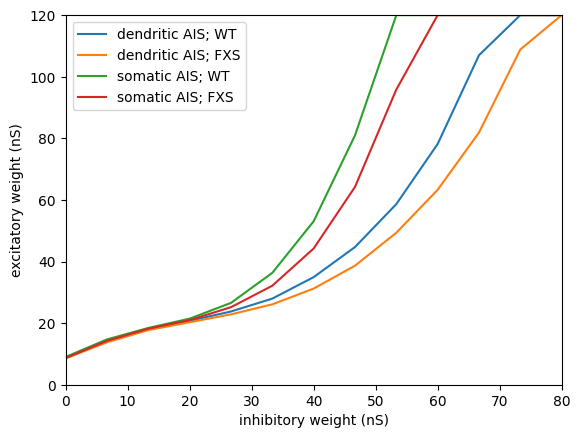

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(inh_values*1e3,np.array(WT_dAIS_threshfire)*1e3,label='dendritic AIS; WT')
ax.plot(inh_values*1e3,np.array(FXS_dAIS_threshfire)*1e3,label='dendritic AIS; FXS')
ax.plot(inh_values*1e3,np.array(WT_sAIS_threshfire)*1e3,label='somatic AIS; WT')
ax.plot(inh_values*1e3,np.array(FXS_sAIS_threshfire)*1e3,label='somatic AIS; FXS')
ax.set_xlabel('inhibitory weight (nS)')
ax.set_ylabel('excitatory weight (nS)')
ax.set_xlim(0,80)
ax.set_ylim(0,120)
ax.legend()